In [1]:
# Importar bibliotecas necesarias
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Comprobar si hay GPU disponible
print("Dispositivos disponibles:")
for device in tf.config.list_physical_devices():
    print(f"  {device.name}")
print(f"¿GPU disponible? {'GPU' in [d.device_type for d in tf.config.list_physical_devices()]}")

# Configurar semilla para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

Dispositivos disponibles:
  /physical_device:CPU:0
¿GPU disponible? False


In [2]:
# Configuración de rutas usando Path para compatibilidad con Windows
BASE_DIR = Path(os.path.join(os.getcwd(), 'data'))
DATASET_DIR = BASE_DIR / 'dataset_parsed'
TRAIN_DIR = DATASET_DIR / 'Training'
TEST_DIR = DATASET_DIR / 'Testing'

print(f"BASE_DIR: {BASE_DIR}")
print(f"DATASET_DIR: {DATASET_DIR}")
print(f"TRAIN_DIR: {TRAIN_DIR}")
print(f"TEST_DIR: {TEST_DIR}")

# Verificar que los directorios existen
if not TRAIN_DIR.exists() or not TEST_DIR.exists():
    print("Error: Los directorios de entrenamiento o prueba no existen.")
    print("Asegúrate de haber ejecutado correctamente el script de preprocesamiento.")
else:
    print("Directorios de datos encontrados correctamente.")

    # Obtener las clases disponibles
    classes = [d.name for d in TRAIN_DIR.iterdir() if d.is_dir()]
    print(f"Clases detectadas: {classes}")
    num_classes = len(classes)

BASE_DIR: c:\Users\Administrator\Documents\GitHub\inteligencia_negocios\data
DATASET_DIR: c:\Users\Administrator\Documents\GitHub\inteligencia_negocios\data\dataset_parsed
TRAIN_DIR: c:\Users\Administrator\Documents\GitHub\inteligencia_negocios\data\dataset_parsed\Training
TEST_DIR: c:\Users\Administrator\Documents\GitHub\inteligencia_negocios\data\dataset_parsed\Testing
Directorios de datos encontrados correctamente.
Clases detectadas: ['glioma', 'meningioma', 'no_tumor', 'pituitary']


In [ ]:
# Configuración de parámetros
IMG_SIZE = 224 
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001

# Configurar aumentación de datos para entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
    validation_split=0.2  # Usar 20% de los datos de entrenamiento como validación
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Preparar generadores de datos
train_generator = train_datagen.flow_from_directory(
    str(TRAIN_DIR),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    str(TRAIN_DIR),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    str(TEST_DIR),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Mapeo de índices a nombres de clases
class_indices = train_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}
print("Mapeo de clases:", class_indices)

Found 6867 images belonging to 4 classes.
Found 1715 images belonging to 4 classes.
Found 1715 images belonging to 4 classes.
Found 1705 images belonging to 4 classes.
Mapeo de clases: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}
Found 1705 images belonging to 4 classes.
Mapeo de clases: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}


Ejemplos del conjunto de entrenamiento:


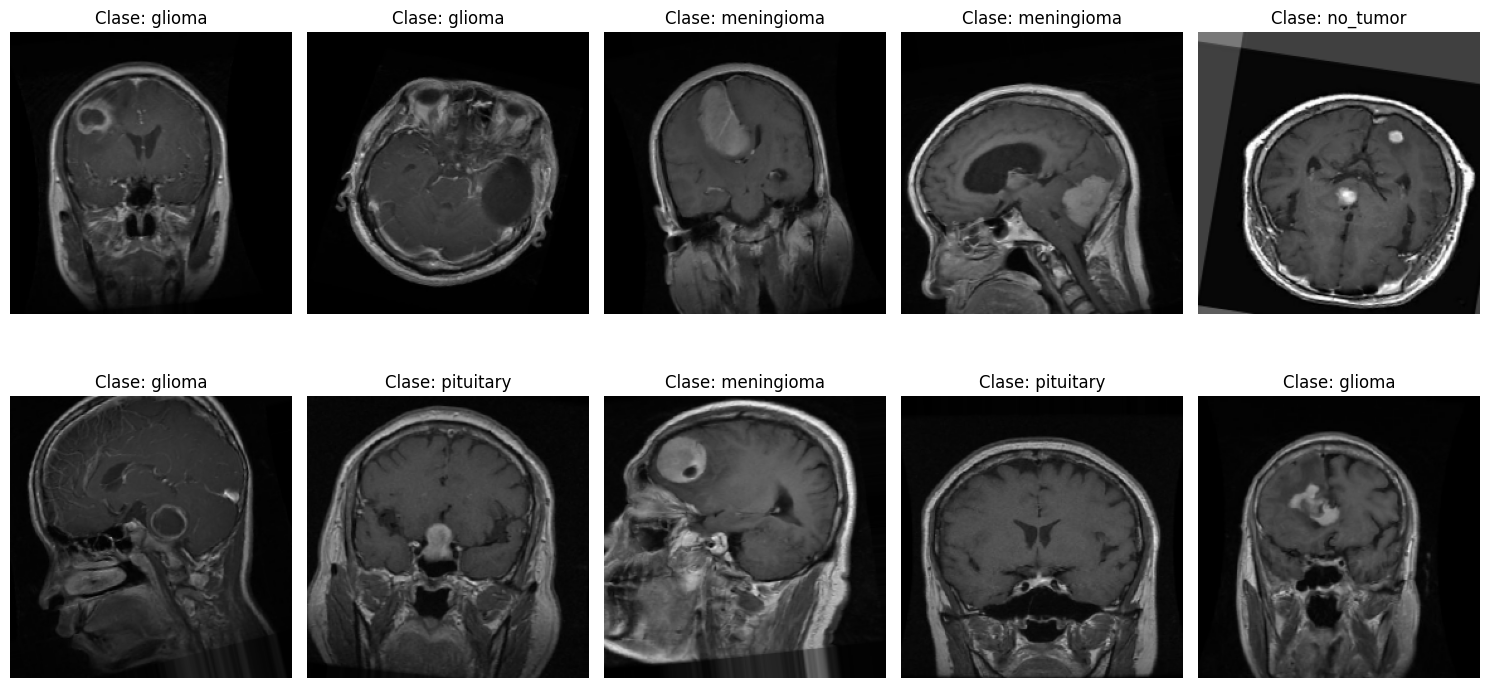

In [4]:
# Función para visualizar algunas imágenes del conjunto de datos
def plot_images_from_generator(generator, num_images=10):
    plt.figure(figsize=(15, 8))
    
    # Obtener un lote de imágenes
    images, labels = next(generator)
    labels = np.argmax(labels, axis=1)
    
    # Mostrar imágenes
    for i in range(min(num_images, len(images))):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f"Clase: {class_names[labels[i]]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Mostrar ejemplos del conjunto de entrenamiento
print("Ejemplos del conjunto de entrenamiento:")
plot_images_from_generator(train_generator)

In [5]:
# Definir arquitectura de la CNN
def create_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=num_classes):
    model = Sequential()
    
    # Primera capa convolucional
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Segunda capa convolucional
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Tercera capa convolucional
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Cuarta capa convolucional
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Aplanar para capas densas
    model.add(Flatten())
    
    # Capas densas (fully connected)
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # Capa de salida con activación softmax para clasificación multiclase
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compilar modelo
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Crear modelo
model = create_model()
model.summary()

c:\Users\Administrator\Documents\GitHub\inteligencia_negocios\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,216,388 (100.01 MB)

 Trainable params: 26,213,892 (100.00 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [6]:
# Configurar callbacks para mejorar el entrenamiento
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

# Entrenar el modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

c:\Users\Administrator\Documents\GitHub\inteligencia_negocios\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.6060 - loss: 1.0962 - val_accuracy: 0.2335 - val_loss: 2.9469 - learning_rate: 0.0010
Epoch 2/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.6060 - loss: 1.0962 - val_accuracy: 0.2335 - val_loss: 2.9469 - learning_rate: 0.0010
Epoch 2/20
  1/214 ━━━━━━━━━━━━━━━━━━━━ 2:33 720ms/step - accuracy: 0.8750 - loss: 0.5245

c:\Users\Administrator\Documents\GitHub\inteligencia_negocios\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


214/214 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.8750 - loss: 0.5245 - val_accuracy: 0.2311 - val_loss: 2.8705 - learning_rate: 0.0010
Epoch 3/20
Epoch 3/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 164s 767ms/step - accuracy: 0.7377 - loss: 0.7010 - val_accuracy: 0.2488 - val_loss: 2.4837 - learning_rate: 0.0010
Epoch 4/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 164s 767ms/step - accuracy: 0.7377 - loss: 0.7010 - val_accuracy: 0.2488 - val_loss: 2.4837 - learning_rate: 0.0010
Epoch 4/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - accuracy: 0.8438 - loss: 0.5073 - val_accuracy: 0.2588 - val_loss: 2.3982 - learning_rate: 0.0010
Epoch 5/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - accuracy: 0.8438 - loss: 0.5073 - val_accuracy: 0.2588 - val_loss: 2.3982 - learning_rate: 0.0010
Epoch 5/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 167s 779ms/step - accuracy: 0.7878 - loss: 0.5436 - val_accuracy: 0.6533 - val_loss: 1.0395 - learning_rate: 0.0010
Epoch 6/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 167s 779ms/step - accuracy: 0.

In [ ]:
# Visualizar gráficos de entrenamiento
plt.figure(figsize=(12, 5))

# Gráfico de precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='lower right')

# Gráfico de pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluar el modelo en datos de prueba
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Precisión en datos de prueba: {test_accuracy:.4f}")
print(f"Pérdida en datos de prueba: {test_loss:.4f}")

# Calcular matriz de confusión y reporte de clasificación
y_pred = []
y_true = []

# Reiniciar el generador
test_generator.reset()

# Predecir clases para todo el conjunto de prueba
for i in range(len(test_generator)):
    if i >= len(test_generator):
        break
    x, y = test_generator[i]
    y_pred_batch = model.predict(x)
    y_pred.extend(np.argmax(y_pred_batch, axis=1))
    y_true.extend(np.argmax(y, axis=1))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names.values(), 
            yticklabels=class_names.values())
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.tight_layout()
plt.show()

# Reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names.values()))

In [ ]:
# Guardar el modelo entrenado
MODEL_DIR = Path(os.path.join(os.getcwd(), 'models'))

# Crear directorio si no existe
if not MODEL_DIR.exists():
    MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Guardar modelo
model_path = MODEL_DIR / 'brain_tumor_cnn_model.h5'
model.save(str(model_path))
print(f"Modelo guardado en: {model_path}")

# También guardar arquitectura del modelo en formato JSON
model_json = model.to_json()
json_path = MODEL_DIR / 'brain_tumor_cnn_model.json'
with open(json_path, "w") as json_file:
    json_file.write(model_json)
print(f"Arquitectura del modelo guardada en: {json_path}")

In [ ]:
# Función para hacer predicciones en nuevas imágenes
def predict_image(image_path, model, img_size=IMG_SIZE):
    """
    Predice la clase de una imagen
    
    Args:
        image_path: Ruta a la imagen
        model: Modelo entrenado
        img_size: Tamaño de entrada del modelo
    
    Returns:
        Etiqueta predicha y probabilidades
    """
    # Cargar y preprocesar imagen
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=(img_size, img_size)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    
    # Hacer predicción
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    probabilities = predictions[0]
    
    return predicted_class, probabilities

# Demo: Probar con una imagen de ejemplo (descomenta para usar)
"""
sample_img_path = str(TEST_DIR / "glioma" / "algunaimagen.jpg")  # Ajusta la ruta según tu estructura

if Path(sample_img_path).exists():
    predicted_class, probabilities = predict_image(sample_img_path, model)
    
    plt.figure(figsize=(6, 6))
    img = plt.imread(sample_img_path)
    plt.imshow(img)
    plt.title(f"Predicción: {class_names[predicted_class]} ({probabilities[predicted_class]:.2%})")
    plt.axis('off')
    plt.show()
    
    # Mostrar todas las probabilidades
    plt.figure(figsize=(10, 3))
    sns.barplot(x=list(class_names.values()), y=probabilities)
    plt.ylabel('Probabilidad')
    plt.xlabel('Clase')
    plt.title('Distribución de probabilidades por clase')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
"""